In [130]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
!pip3 install seaborn

    100% |████████████████████████████████| 215kB 14.9MB/s ta 0:00:01
You are using pip version 19.0.3, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [312]:
%load_ext autoreload
%autoreload 2
from utils import *

import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import os
import lightgbm as lgbm
import warnings
from utils import *
import seaborn as sns
from sklearn.metrics import accuracy_score
from parameters import top_tickers, ibkr_info

sns.set()

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
np.array(list(ibkr_info.keys()))

array(['RNFT', 'PHOR', 'CBOM', 'POLY', 'TATNP', 'RTKM', 'PLZL', 'DSKY',
       'SFIN', 'IRAO', 'HYDR', 'RUAL', 'SNGSP', 'LKOH', 'MTLR', 'CHMF',
       'MVID', 'TATN', 'ALRS', 'MTSS', 'MGNT', 'NLMK', 'GAZP', 'GMKN',
       'YNDX', 'AFLT', 'AFKS', 'TRMK', 'MAGN', 'SNGS', 'FIVE', 'PIKK',
       'FEES', 'MOEX'], dtype='<U5')

In [36]:
load_tickers(data_prefix="data/train", tickers=np.array(list(ibkr_info.keys())), start_date=datetime.strptime("20170101", "%Y%m%d").date(), end_date=datetime.today().date() + timedelta(days=1), period=3)

100%|██████████| 30/30 [09:35<00:00, 19.04s/it]


In [3]:
ticker2df = load_dfs('data/train', np.array(list(ibkr_info.keys())))

In [371]:
test_start_day = datetime.today().date() - timedelta(days=30)

train_dates = [test_start_day - timedelta(days=x) for x in range(1, 500)]
val_dates = [test_start_day + timedelta(days=x) for x in range(0, 30)]

In [372]:
X_train, train_target_dfs = all_samples(ticker2df, train_dates)
X_val, val_target_dfs = all_samples(ticker2df, val_dates)

In [315]:
X_train.shape

(2040, 129)

In [382]:
y_train_profit = calc_target(train_target_dfs, single_profit_2, target_df_2_one_day_series)
y_val_profit = calc_target(val_target_dfs, single_profit_2, target_df_2_one_day_series)

y_train = calc_target(train_target_dfs, single_target_3, target_df_2_half_day_series) > 0.01
y_val = calc_target(val_target_dfs, single_target_3, target_df_2_half_day_series) > 0.01

lgb = lgbm.sklearn.LGBMClassifier()
lgb.fit(X_train.drop(['corn_date', 'ticker'], axis=1), y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [383]:
lgb.feature_importances_

array([113,  28,  23,  37,  35,  23,  22,  30,  19,  32,  25,  16,  24,
        34,  25,  31,  19,  37,  48,   9,  12,  40,  45,  33,  20,  62,
        68,  24,  35,  12,  32,  24,  21,  18,  26,  25,  20,  42,  28,
        16,  24,   7,  23,  16,  19,  26,  25,  14,  13,  14,  23,   8,
        11,  22,  21,  11,   5,  16,  15,   7,   0,  14,   3,   4,  14,
        10,   0,  12,   5,   0,  17,  25,   0,  25,  24,  27,  15,  11,
        13,  16,   8,  16,  35,  24,   0,  21,  24,  20,  24,  17,  33,
        17,  34,  28,  25,  18,  32,  28,  20,  16,  16,  26,  38,  39,
        30,  23,  18,  25,  25,  35,  19,  28,  24,  16,  24,  34,  37,
        26,  26,  31,  29,  30,  43,  33,  19,  45,  33])

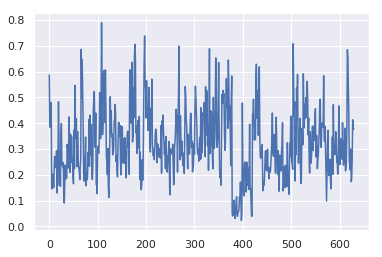

In [375]:
try:
    del X_val['profit']
    del X_val['profit_abs']
except:
    None

pred_proba = lgb.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
#pred_proba = lgb.predict(X_val.drop(['corn_date', 'ticker'], axis=1))

plt.plot(pred_proba)
plt.show()

# pred_proba_2 = lgb_2.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
# plt.plot(pred_proba_2)
# plt.show()

# pred_proba_3 = lgb_3.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
# plt.plot(pred_proba_3)

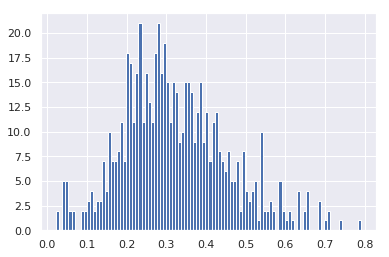

In [376]:
plt.hist(pred_proba, bins=100)
plt.show()

In [377]:
top_idxs = np.where(pred_proba > 0.5)[0]
len(top_idxs)

63

In [378]:
y_val.mean(), y_val[top_idxs].mean()

(0.33174603174603173, 0.4444444444444444)

In [621]:
y_val.mean(), y_val[top_idxs].mean()

(0.14666666666666667, 0.5625)

In [379]:
X_val['profit'] = y_val_profit
day_cnt_df = X_val.loc[top_idxs].groupby('corn_date').size().reset_index().rename({0:'cnt_per_day'}, axis=1)
X_val = pd.merge(X_val, day_cnt_df, on='corn_date', how='left')
X_val['volume'] = 2500000 / X_val['cnt_per_day']
X_val['profit_abs'] = X_val['volume'] * X_val['profit']
del X_val['cnt_per_day']
del X_val['volume']

In [380]:
X_val.loc[top_idxs].groupby('corn_date')['profit_abs'].sum()

corn_date
2019-08-06    14269.617178
2019-08-07   -33687.724070
2019-08-08    -7230.237355
2019-08-09   -22432.778843
2019-08-12        0.000000
2019-08-13   -15764.582239
2019-08-14   -29303.495763
2019-08-15   -20637.879136
2019-08-16   -22879.106514
2019-08-19      509.909802
2019-08-20    -1070.390599
2019-08-21    10802.867763
2019-08-22   -42039.355993
2019-08-23   -30463.922012
2019-08-26    20000.000000
2019-08-27   -21642.892277
2019-08-28    27050.717804
2019-08-29    30000.000000
2019-09-02        0.000000
2019-09-03    -6780.460585
Name: profit_abs, dtype: float64

In [381]:
X_val.loc[top_idxs]['profit_abs'].sum()

-151299.71283786336

In [ ]:
104962.15800748912

In [161]:
28292 / 2500000

0.0113168

In [22]:
X_val.loc[top_idxs]['profit_abs'].sum()

-205164.9234591169

In [ ]:
249540.7438308383
238265.8202385087
182758.77619388318
124229.31720323926
91517.8617101984
84287.5011097007

In [325]:
X_day = X_val.loc[top_idxs]
X_day = X_day[X_day['corn_date'] == datetime.strptime("20190830", "%Y%m%d").date()]

In [326]:
X_day

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,ticker,corn_date,profit,profit_abs
375,0.0,0.052661,0.975007,0.869956,0.980296,0.201135,-0.03058,0.033445,1.064953,0.98625,...,0.001198,-0.005844,0.00805,0.004961,0.001294,0.00412,MTLR,2019-08-30,-0.026669,-66672.120419


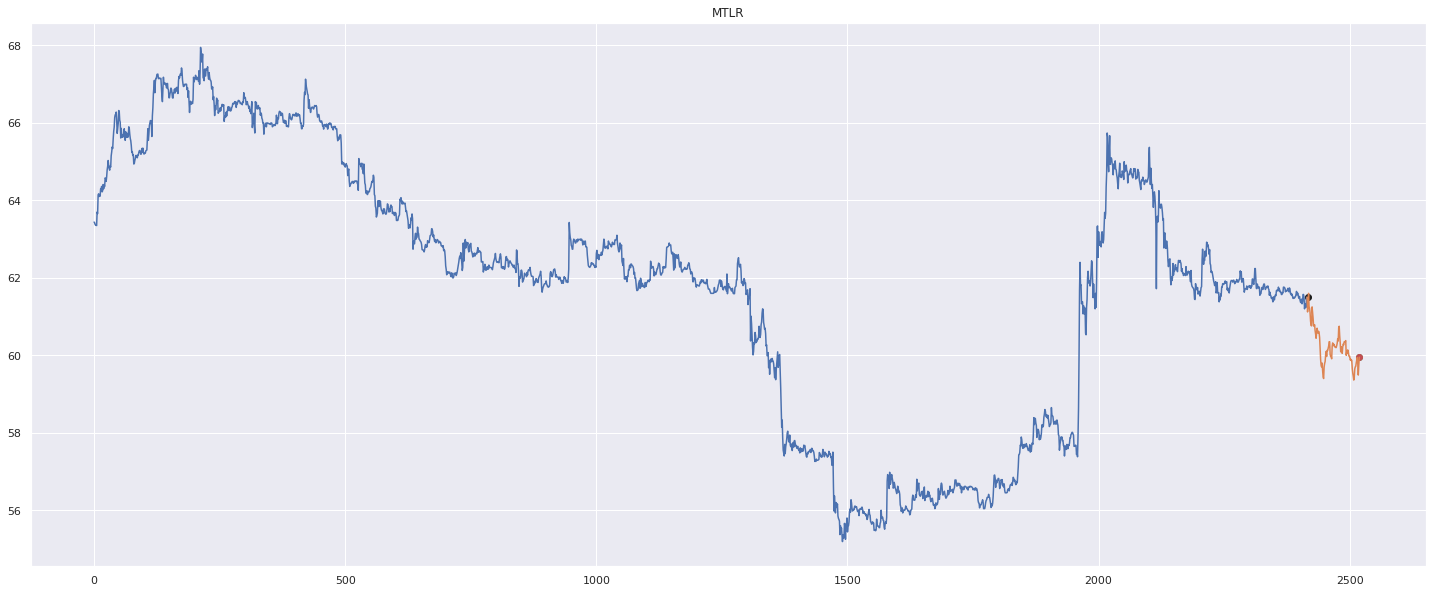

datetime.date(2019, 8, 30)

In [327]:
idx = 375
#for idx in top_idxs:
corn_date = X_val.loc[idx]['corn_date']
ticker = X_val.loc[idx]['ticker']

df = ticker2df[ticker]
month_series = df_between(df, corn_date - timedelta(days=31), corn_date)['<OPEN>'].values
target_series = df_between(df, corn_date, corn_date + timedelta(days=3))['<OPEN>'].values


plt.figure(figsize=(25,10))
plt.title(ticker)
plt.plot(range(len(month_series)), month_series)
plt.plot(range(len(month_series), len(month_series) + len(target_series)), target_series)

buy_idx, sell_idx = single_profit_2(np.array([0] + list(target_series)), return_idxs=True)
plt.scatter(len(month_series) + 1, target_series[0], color='k')
plt.scatter(len(month_series) + buy_idx - 1, target_series[buy_idx - 1], color='g')
plt.scatter(len(month_series) + sell_idx - 1, target_series[sell_idx - 1], color='r')

#plt.plot(range(len(month_series), len(month_series) + len(target_series)), y_val_series[84][-8], color='r')




plt.show()
corn_date

In [658]:
int(datetime.now().strftime('%H'))

20

In [659]:
lgb

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [662]:
import pickle
with open('models/lgb_26_09_thr04.pickle', 'wb') as f:
    pickle.dump(lgb, f)

# Inference

In [810]:
train_dates = [datetime.today().date() - timedelta(days=x) for x in range(1, 100)]

In [811]:
X_train, y_train_series = all_samples(ticker2df, train_dates)


In [ ]:
y_train_profit = calc_target(y_train_series, single_profit_2) 

y_train = calc_target(y_train_series, single_target_3) > 0.01

lgb = lgbm.sklearn.LGBMClassifier()
lgb.fit(X_train.drop(['corn_date', 'ticker'], axis=1), y_train)

In [48]:
test_start_day

datetime.date(2019, 7, 4)

In [19]:
load_tickers(data_prefix="data/current", tickers=np.array(list(ibkr_info.keys())), start_date=datetime.today().date() - timedelta(days=40), end_date=datetime.today().date(), period=3)

100%|██████████| 30/30 [00:47<00:00,  1.51s/it]


In [20]:
ticker2df_test = load_dfs('data/current', np.array(list(ibkr_info.keys())))

In [21]:
X_test, y_test_series = all_samples(ticker2df_test, [datetime.today().date()], test_mode=True)

In [18]:
import pickle
with open('models/lgb_26_09_thr04.pickle', 'rb') as f:
    lgb = pickle.load(f)

In [22]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,ticker,corn_date
0,0.021724,0.951977,0.905969,0.953820,0.094031,0.060715,0.011657,0.978789,0.950862,0.975817,...,0.004134,0.008663,0.001327,0.003677,1.016772,1.028416,1.006907,1.015147,GMKN,2019-08-27
1,0.009623,0.977552,0.950277,0.979064,0.049723,0.012469,0.007271,0.980474,0.969051,0.976672,...,0.003546,0.011759,0.000544,0.002469,1.015058,1.038844,1.002980,1.012141,SNGSP,2019-08-27
2,0.019066,0.945465,0.921560,0.935583,0.078440,0.058282,0.007268,0.977620,0.945881,0.979842,...,0.004344,0.014806,0.001269,0.003529,1.019089,1.055137,1.006063,1.014154,MVID,2019-08-27
3,0.013716,0.966187,0.938444,0.963894,0.061556,0.016553,0.009044,0.980603,0.965911,0.978721,...,0.003316,0.006447,0.000846,0.002947,1.014063,1.026113,1.006091,1.013712,MOEX,2019-08-27
4,0.018336,0.954951,0.930019,0.948900,0.069981,-0.052832,0.005110,0.988406,0.977604,0.988711,...,0.002790,0.005556,0.000863,0.002807,1.011985,1.018735,1.005510,1.012391,HYDR,2019-08-27
5,0.025615,0.944620,0.895979,0.952506,0.104021,-0.030449,0.003113,0.991780,0.983254,0.992101,...,0.004105,0.010455,0.001438,0.003000,1.018352,1.040062,1.007419,1.016541,TATNP,2019-08-27
6,0.021078,0.963926,0.926320,0.967297,0.073680,0.040977,0.011926,0.972680,0.954096,0.972299,...,0.003108,0.005075,0.001069,0.002846,1.013583,1.026771,1.004651,1.012097,PHOR,2019-08-27
7,0.014569,0.961384,0.930334,0.961222,0.069666,-0.021789,0.004639,0.987924,0.969250,0.988239,...,0.003939,0.007019,0.001062,0.003742,1.017470,1.026671,1.005981,1.018019,GAZP,2019-08-27
8,0.005999,0.989870,0.973829,0.992499,0.026171,-0.023004,0.004201,0.988362,0.982344,0.987052,...,0.000869,0.002763,0.000299,0.000740,1.003756,1.014999,1.001347,1.002852,CBOM,2019-08-27
9,0.041999,0.930183,0.855177,0.940681,0.144823,0.143420,0.009210,0.973429,0.950568,0.970875,...,0.004529,0.013348,0.001063,0.003705,1.018374,1.045130,1.006192,1.016175,PLZL,2019-08-27


In [745]:
# del X_test['profit']
# del X_test['profit_abs']

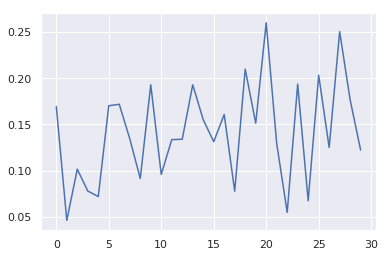

In [23]:
pred_proba = lgb.predict_proba(X_test.drop(['corn_date', 'ticker'], axis=1))[:, 1]
plt.plot(pred_proba)
plt.show()


In [821]:
16990000 * 0.039235

666602.65

In [24]:
top_idxs = np.where(pred_proba > 0.25)[0]
top_idxs

array([20, 27])

In [25]:
ticker2price = {}

for ticker in list(X_test.loc[top_idxs, ['ticker', 'corn_date']]['ticker'].values):
    
    df = ticker2df_test[ticker]
    price = df[df['date']==datetime.today().date()]['<OPEN>'].values[0]
    
    ticker2price[ticker] = price


ticker2price

{'AFKS': 11.338, 'RUAL': 25.99}

In [26]:
y_test_profit = calc_target(y_test_series, single_profit_2)

In [27]:
X_test['profit'] = y_test_profit
day_cnt_df = X_test.loc[top_idxs].groupby('corn_date').size().reset_index().rename({0:'cnt_per_day'}, axis=1)
X_test = pd.merge(X_test, day_cnt_df, on='corn_date', how='left')
X_test['volume'] = 2000000 / X_test['cnt_per_day']
X_test['profit_abs'] = X_test['volume'] * X_test['profit']
del X_test['cnt_per_day']
del X_test['volume']

In [28]:
top_idxs

array([20, 27])

In [29]:
X_test.loc[top_idxs, ['ticker', 'corn_date']]

,ticker,corn_date
20,AFKS,2019-08-27
27,RUAL,2019-08-27


In [30]:
X_test.loc[top_idxs, ['ticker', 'corn_date', 'profit', 'profit_abs']]

,ticker,corn_date,profit,profit_abs
20,AFKS,2019-08-27,-0.000352,-351.957765
27,RUAL,2019-08-27,-0.001727,-1727.115717


In [649]:
X_test.loc[top_idxs, ['profit']].sum()

profit    0.036
dtype: float64

In [650]:
X_test.loc[top_idxs, ['profit_abs']].sum()

profit_abs    24000.0
dtype: float64

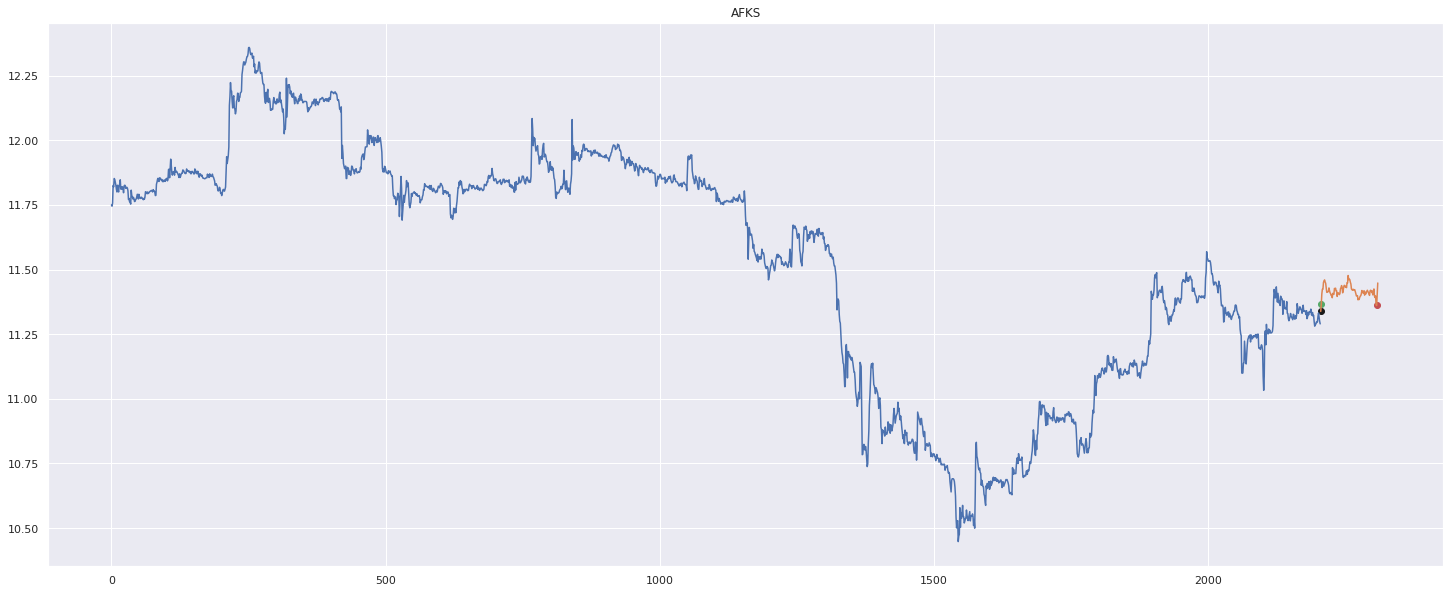

In [33]:
idx = 20
#for idx in top_idxs:
corn_date = X_test.loc[idx]['corn_date']
ticker = X_test.loc[idx]['ticker']

df = ticker2df_test[ticker]
month_series = df_between(df, corn_date - timedelta(days=31), corn_date)['<OPEN>'].values
target_series = df_between(df, corn_date, corn_date + timedelta(days=1))['<OPEN>'].values


plt.figure(figsize=(25,10))
plt.title(ticker)
plt.plot(range(len(month_series)), month_series)
plt.plot(range(len(month_series), len(month_series) + len(target_series)), target_series)

buy_idx, sell_idx = single_profit_2(np.array([0] + list(target_series)), return_idxs=True)
plt.scatter(len(month_series) + 1, target_series[0], color='k')
plt.scatter(len(month_series) + buy_idx - 1, target_series[buy_idx - 1], color='g')
plt.scatter(len(month_series) + sell_idx - 1, target_series[sell_idx - 1], color='r')

#plt.plot(range(len(month_series), len(month_series) + len(target_series)), y_val_series[84][-8], color='r')

# plt.axhline(y=11.573, linewidth=4, color='g')
# plt.axhline(y=11.675, linewidth=4, color='r')



plt.show()



In [353]:
    series = np.array([0] + list(target_series))
    UPPER_COEF = 1.003
    BUY_HORIZON = 118
    can_buy = (series[2:BUY_HORIZON] <= series[1]*UPPER_COEF).max()

In [354]:
can_buy

False

In [352]:
series[2:BUY_HORIZON] <= series[1]*UPPER_COEF

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [356]:
series

array([  0.  , 223.62, 225.25, 225.69, 225.52, 226.03, 225.69, 224.99,
       225.61, 225.81, 225.4 , 225.53, 225.33, 225.2 , 224.4 , 224.64,
       224.66, 225.03, 224.94, 225.13, 224.96, 225.48, 225.53, 225.64,
       225.49, 225.4 , 224.88, 225.23, 225.08, 225.3 , 225.35, 225.28,
       225.39, 225.35, 225.58, 225.59, 225.8 , 225.69, 225.45, 225.42,
       225.29, 225.27, 225.05, 225.26, 225.49, 225.4 , 225.33, 225.15,
       225.46, 225.44, 226.29, 226.2 , 225.98, 226.14, 226.12, 226.48,
       226.47, 227.21, 227.35, 226.8 , 226.63, 227.17, 227.06, 226.84,
       226.89, 226.69, 226.5 , 226.56, 226.31, 226.54, 226.55, 226.68,
       226.34, 226.4 , 226.55, 226.51, 226.4 , 226.53, 226.63, 226.28,
       226.7 , 226.12, 226.58, 226.69, 227.16, 227.23, 227.27, 227.17,
       226.93, 226.71, 226.93, 226.66, 226.99, 226.94, 226.95, 227.05,
       226.85, 226.95, 226.84, 226.61, 226.47, 226.54, 226.9 , 226.98,
       227.04, 226.76])

In [654]:
datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

In [ ]:
data_prefix='data/train'
start_date=datetime.today().date() - timedelta(days=1)
end_date = datetime.today().date() + timedelta(days=1)

ticker='LKOH'
load_single(ticker, 'data/temp', start_date, end_date, 3)


df = pd.read_csv('data/train/{}.csv'.format(ticker))
df['date'] = df['<DATE>'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date())

upd_df = pd.read_csv('data/temp/{}.csv'.format(ticker))
upd_df['date'] = upd_df['<DATE>'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date())